In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install zipfile36 --quiet
!pip install uszipcode --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.5/121.5 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 KB 5.8 MB/s eta 0:00:00


In [3]:
from zipfile import ZipFile

with ZipFile("src.zip", 'r') as zObject:
	zObject.extractall()

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

from src.data.feature_extractor import FeatureExtractor
from src.data.importer import DataImporter
from src.data.ratings_dataset import RatingsDataset
from src.model.candidate_generation import CandidateGeneration
from src.model.popularity import Popularity
from src.trainer import Trainer
from src.utils import get_device
from src.model.candidate_generation_from_transformer import CandidateGenerationT

/usr/local/lib/python3.8/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# EDA

### Fetch MovieLens100k data

In [5]:
data_importer = DataImporter('http://files.grouplens.org/datasets/movielens/ml-100k.zip')
users_df, movies_df, genres, ratings_df = data_importer.import_data()

### Data exploration

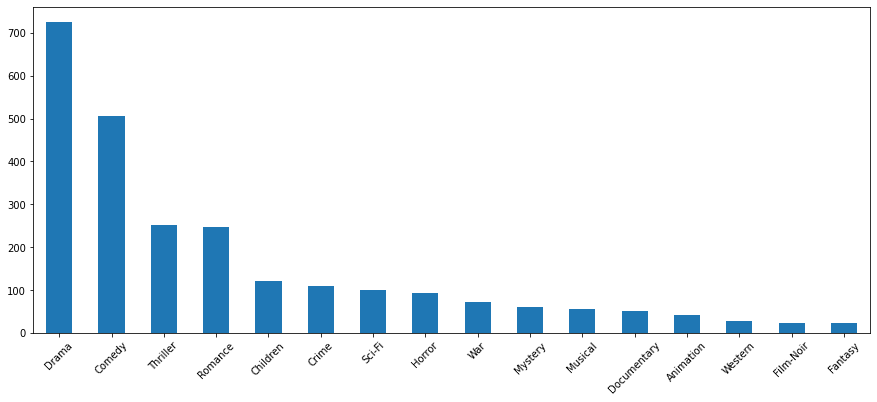

In [6]:
plt.figure(figsize=(15,6))
movies_df.iloc[:,5:].sum().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=45)
plt.show();

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


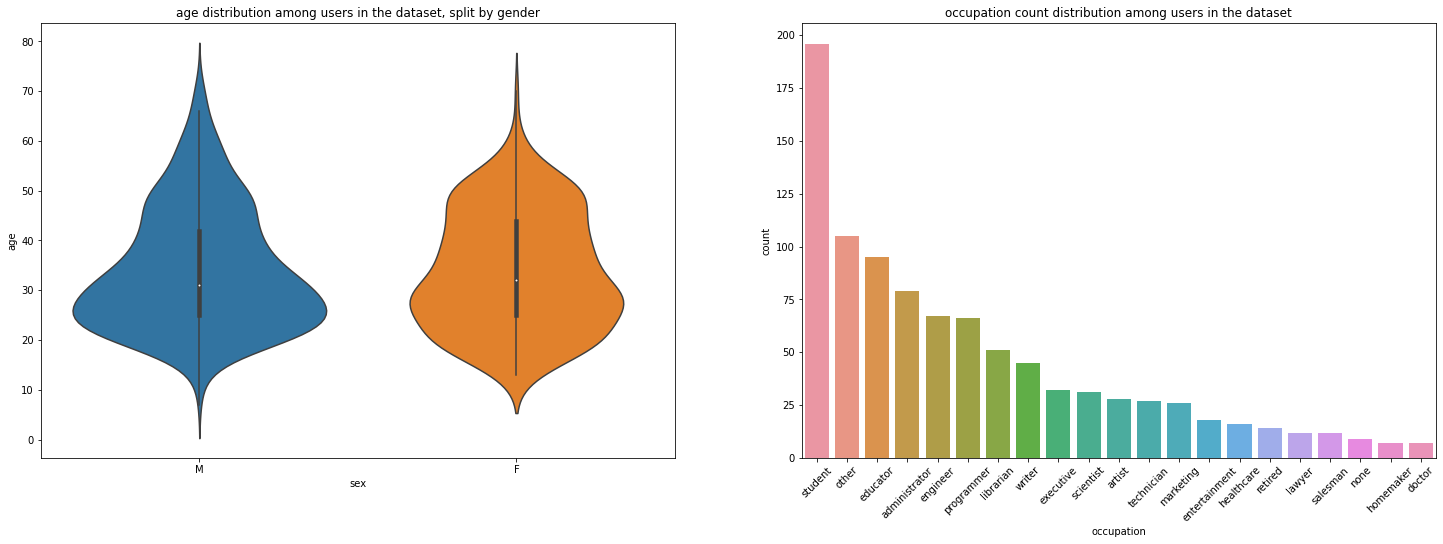

In [7]:

_, ax = plt.subplots(1,2, figsize=(25,8))
sns.violinplot(data=users_df, y='age', ax=ax[0], x='sex')
sns.countplot(users_df.occupation, ax=ax[1], order = users_df.occupation.value_counts().index)
plt.xticks(rotation=45)
ax[0].set(title='age distribution among users in the dataset, split by gender')
ax[1].set(title='occupation count distribution among users in the dataset');

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


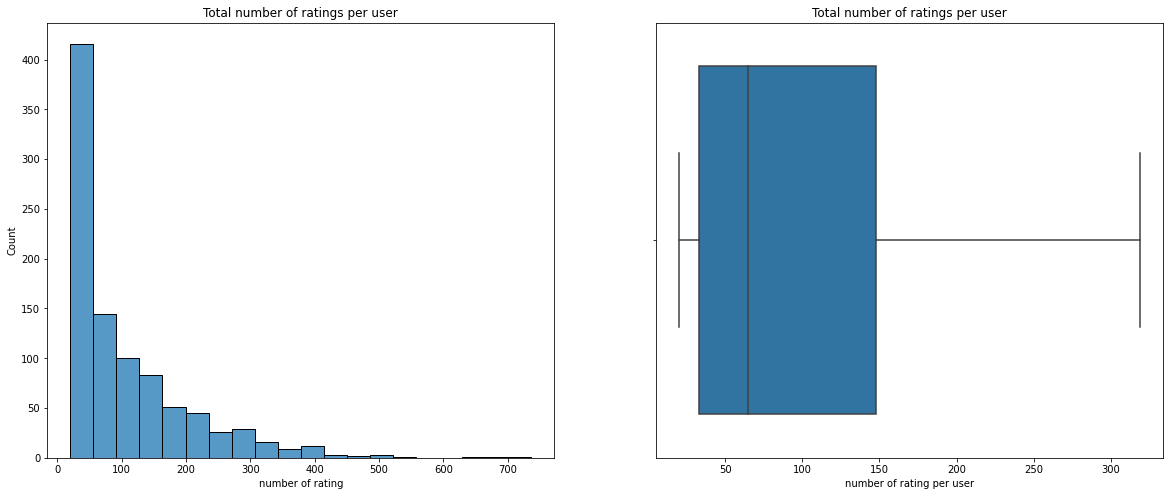

In [8]:

ratings_per_user = ratings_df.groupby('user_id')['rating'].count()
_, ax = plt.subplots(1,2, figsize=(20,8))
sns.histplot(ratings_per_user, ax=ax[0], bins=20)
sns.boxplot(ratings_per_user, ax=ax[1], showfliers=False)
ax[0].set(xlabel='number of rating', title='Total number of ratings per user')
ax[1].set(xlabel='number of rating per user', title='Total number of ratings per user');


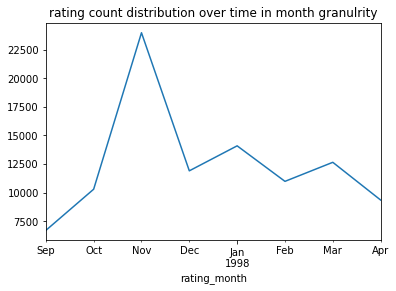

In [9]:
df = ratings_df.copy()
df['rating_month'] = df['rating_date'].dt.to_period('M')
ratings_count = df.groupby('rating_month')['rating'].count()
ratings_count.plot()
plt.title('rating count distribution over time in month granulrity');

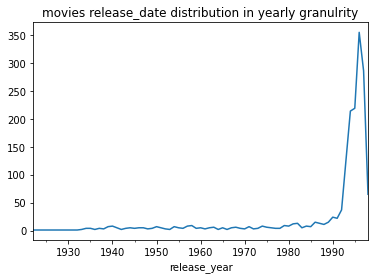

In [10]:
df = movies_df.copy()
df['release_year'] = df['release_date'].dt.to_period('Y')
items_count = df.groupby('release_year')['title'].count()
items_count.plot()
plt.title('movies release_date distribution in yearly granulrity');

# Data Preprocessing

### Generate features and create examples df

In [11]:
f_extractor = FeatureExtractor(window_size=16)
examples_df = f_extractor.fit_transform(
    genres=genres,
    movies_df=movies_df,
    users_df=users_df,
    ratings_df=ratings_df
)

One-Hot user occupation matrix shape (943, 21)
One-Hot user gender matrix shape (943, 2)
Download /root/.uszipcode/simple_db.sqlite from https://github.com/MacHu-GWU/uszipcode-project/releases/download/1.0.1.db/simple_db.sqlite ...
  1.00 MB downloaded ...
  2.00 MB downloaded ...
  3.00 MB downloaded ...
  4.00 MB downloaded ...
  5.00 MB downloaded ...
  6.00 MB downloaded ...
  7.00 MB downloaded ...
  8.00 MB downloaded ...
  9.00 MB downloaded ...
  10.00 MB downloaded ...
  11.00 MB downloaded ...
  Complete!
One-Hot user geo area matrix shape (943, 4)
Using 90 examples per user_id
Using 32 examples per label
Examples shape  (49440, 7)


## Split train/validation examples

In [12]:
train_df, val_df = train_test_split(examples_df)

# Train Loader
train_dataset = RatingsDataset.from_df(train_df)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

# Validation Loader
val_dataset = RatingsDataset.from_df(val_df)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

### Train Candidate generation model

In [13]:
EMBEDDING_DIMS = 256
DENSE_UNITS = 256
USER_DIM = 64
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
EPOCHS = 10

In [17]:
device = get_device()

cg_model = CandidateGeneration(
    n_items=movies_df.index.astype(int).max() + 2,
    n_search_items=len(genres) + 1,
    n_features=len(examples_df.iloc[0]['features']),
    embedding_dim=EMBEDDING_DIMS,
    fc_layers=(2048, 1024, 512, 256),
    user_dim=USER_DIM
).to(device)

opt = Adam(cg_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
crit = CrossEntropyLoss().to(device)

CUDA is available!  Training on GPU ...


In [18]:
trainer = Trainer(cg_model, opt, crit, device)
train_losses, val_losses = trainer.train(train_loader, val_loader, epochs=EPOCHS)

Epoch 1/10, train loss: 7.3064, val loss: 7.1860, time: 1.30s
Epoch 2/10, train loss: 6.8965, val loss: 6.8627, time: 1.34s
Epoch 3/10, train loss: 6.4582, val loss: 6.5338, time: 1.33s
Epoch 4/10, train loss: 5.9890, val loss: 6.2226, time: 1.27s
Epoch 5/10, train loss: 5.5021, val loss: 5.9512, time: 1.81s
Epoch 6/10, train loss: 4.9938, val loss: 5.6738, time: 1.20s
Epoch 7/10, train loss: 4.4495, val loss: 5.4384, time: 1.32s
Epoch 8/10, train loss: 3.8885, val loss: 5.2263, time: 1.32s
Epoch 9/10, train loss: 3.3095, val loss: 5.0779, time: 1.32s
Epoch 10/10, train loss: 2.7187, val loss: 4.9487, time: 1.50s


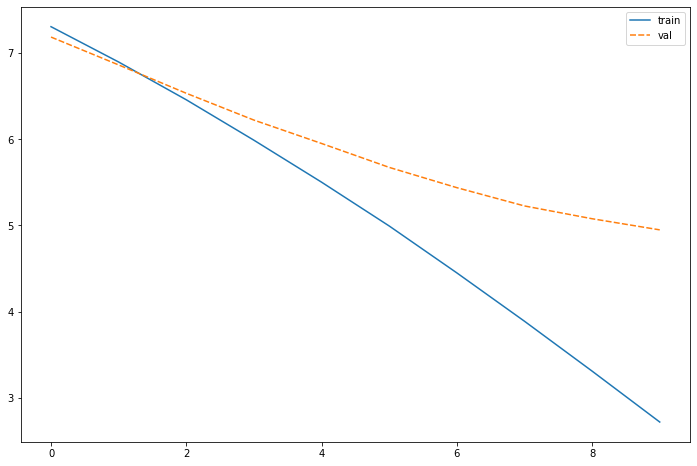

In [19]:
_, ax = plt.subplots(1, figsize=(12, 8))
sns.lineplot(data=pd.DataFrame({'train': train_losses, 'val': val_losses}), ax=ax);

### Evaluate Original Model


In [20]:
k = 10
print(f'candidate generation validation mrr @ {k}: ', cg_model.mrr(val_loader, k, device))
print(f'candidate generation validation hit rate @ {k}: ', cg_model.hit_rate(val_loader, k, device))

candidate generation validation mrr @ 10:  0.4040474545955658
candidate generation validation hit rate @ 10:  0.47161458333333334


### POP model (Baseline)

In [21]:
pop = Popularity()
pop.fit(ratings_df)

In [22]:
k = 10
print(f'popularity model validation mrr @ {k}: ', pop.mrr(val_loader, k))
print(f'popularity model validation hit rate @ {k}: ', pop.hit_rate(val_loader, k))

popularity model validation mrr @ 10:  0.0011132812546566129
popularity model validation hit rate @ 10:  0.00234375


### Transformer Based Recommendations

In [23]:
device = get_device()

cgt_model = CandidateGenerationT(
    n_items=movies_df.index.astype(int).max() + 2,
    n_search_items=len(genres) + 1,
    n_features=len(examples_df.iloc[0]['features']),
    embedding_dim=EMBEDDING_DIMS,
    fc_layers=(2048, 1024, 512, 256),
    user_dim=USER_DIM
).to(device)

opt = Adam(cgt_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
crit = CrossEntropyLoss().to(device)

CUDA is available!  Training on GPU ...


In [24]:
trainer = Trainer(cgt_model, opt, crit, device)
train_losses, val_losses = trainer.train(train_loader, val_loader, epochs=EPOCHS)

Epoch 1/10, train loss: 7.1780, val loss: 6.9653, time: 17.17s
Epoch 2/10, train loss: 6.5828, val loss: 6.4017, time: 17.38s
Epoch 3/10, train loss: 6.0384, val loss: 5.9324, time: 18.01s
Epoch 4/10, train loss: 5.5110, val loss: 5.5383, time: 18.42s
Epoch 5/10, train loss: 4.9974, val loss: 5.1357, time: 18.13s
Epoch 6/10, train loss: 4.5003, val loss: 4.7778, time: 17.71s
Epoch 7/10, train loss: 4.0101, val loss: 4.4610, time: 17.90s
Epoch 8/10, train loss: 3.5415, val loss: 4.1894, time: 18.13s
Epoch 9/10, train loss: 3.0815, val loss: 3.9611, time: 18.09s
Epoch 10/10, train loss: 2.6330, val loss: 3.7557, time: 18.06s


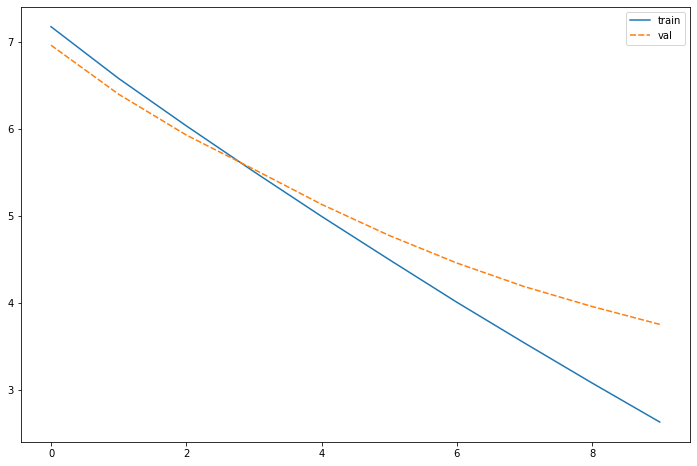

In [25]:
_, ax = plt.subplots(1, figsize=(12, 8))
sns.lineplot(data=pd.DataFrame({'train': train_losses, 'val': val_losses}), ax=ax);

In [26]:
k = 10
print(f'candidate generation w transformer validation mrr @ {k}: ', cgt_model.mrr(val_loader, k, device))
print(f'candidate generation w transformer validation hit rate @ {k}: ', cgt_model.hit_rate(val_loader, k, device))

candidate generation w transformer validation mrr @ 10:  0.5859550404548645
candidate generation w transformer validation hit rate @ 10:  0.6399305555555556


### Compare models

In [27]:
results_df = pd.DataFrame(columns=['model', 'metric', 'k', 'score'])
for m, name in [
    (cg_model, 'Candidate Generation'),
    (pop, 'Popularity'),
    (cgt_model, 'Candidate Generation from Transformer')
]:
    for k in [5, 10, 20]:
        results_df.loc[results_df.shape[0]] = (name, 'mrr', k, m.mrr(val_loader, k, device=device))
        results_df.loc[results_df.shape[0]] = (name, 'hit_rate', k, m.hit_rate(val_loader, k, device=device))

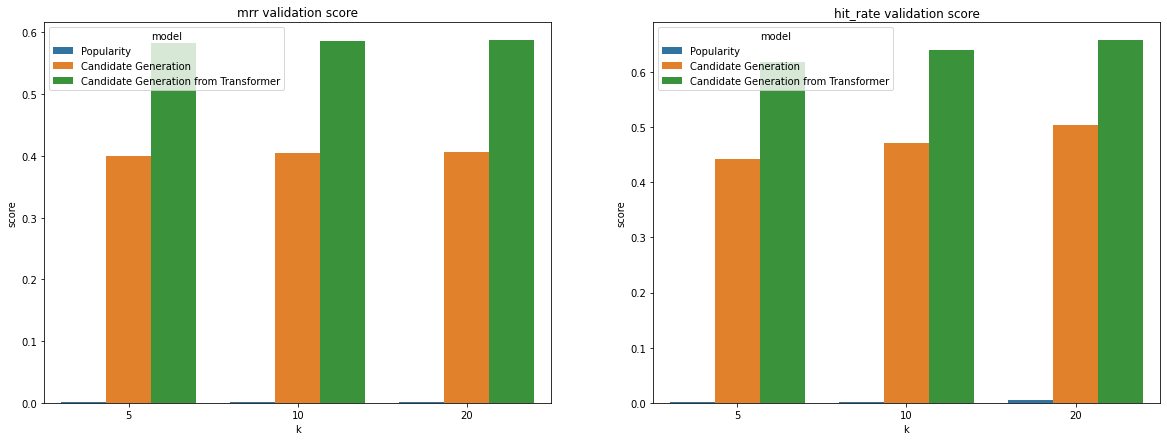

In [28]:
_, ax = plt.subplots(1,2, figsize=(20,7))
for i, metric in enumerate(['mrr', 'hit_rate']):
    data = results_df.loc[results_df.metric==metric].drop(columns=['metric'])
    sns.barplot(data=data.sort_values(by='score'), y='score', x='k', hue='model', ax=ax[i])
    ax[i].set(title=f'{metric} validation score')